In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time

%matplotlib inline

In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

# Feature graph

3198 > 3136 edges
Layer 0: M_0 = |V| = 1008 nodes (224 added),|E| = 3198 edges
Layer 1: M_1 = |V| = 504 nodes (96 added),|E| = 1423 edges
Layer 2: M_2 = |V| = 252 nodes (37 added),|E| = 672 edges
Layer 3: M_3 = |V| = 126 nodes (11 added),|E| = 329 edges
Layer 4: M_4 = |V| = 63 nodes (0 added),|E| = 164 edges
Execution time: 0.14s


/home/mb/anaconda3/envs/tf-cpu/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


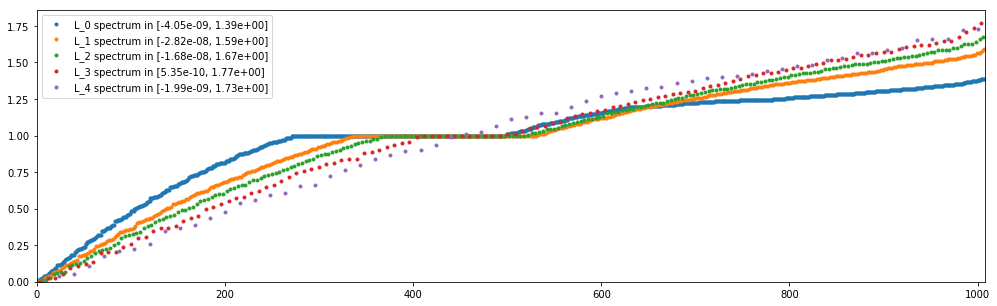

In [7]:
def grid_graph(m, corners=False):
    k=8
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=8, metric='euclidean')
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, k*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(28, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=4, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
graph.plot_spectrum(L)
del A

In [12]:
dir_data=os.path.join('..', 'data', 'mnist')
dir_data

'../data/mnist'

# Data

In [13]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(dir_data, one_hot=False)

train_data = mnist.train.images.astype(np.float32)
val_data = mnist.validation.images.astype(np.float32)
test_data = mnist.test.images.astype(np.float32)
train_labels = mnist.train.labels
val_labels = mnist.validation.labels
test_labels = mnist.test.labels

t_start = time.process_time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Execution time: 1.39s


# Neural networks

In [14]:
#model = fc1()
#model = fc2(nhiddens=100)
#model = cnn2(K=5, F=10)  # K=28 is equivalent to filtering with fgcnn.
#model = fcnn2(F=10)
#model = fgcnn2(L[0], F=10)
#model = lgcnn2_2(L[0], F=10, K=10)
#model = cgcnn2_3(L[0], F=10, K=5)
#model = cgcnn2_4(L[0], F=10, K=5)
#model = cgcnn2_5(L[0], F=10, K=5)

if False:
    K = 5  # 5 or 5^2
    t_start = time.process_time()
    mnist.test._images = graph.lanczos(L, mnist.test._images.T, K).T
    mnist.train._images = graph.lanczos(L, mnist.train._images.T, K).T
    model = lgcnn2_1(L, F=10, K=K)
    print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
    ph_data = tf.placeholder(tf.float32, (FLAGS.batch_size, mnist.train.images.shape[1], K), 'data')

In [15]:
common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 20
common['batch_size']     = 100
common['decay_steps']    = mnist.train.num_examples / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(mnist.train.labels) + 1  # number of classes

model_perf = utils.model_perf()

In [16]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 5e-4
    params['dropout']        = 1
    params['learning_rate']  = 0.02
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1008
  layer 1: logits (softmax)
    representation: M_1 = 10
    weights: M_0 * M_1 = 1008 * 10 = 10080
    biases: M_1 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.38e-01
  validation accuracy: 91.00 (4550 / 5000), f1 (weighted): 90.95, loss: 3.62e-01
  time: 13s (wall 5s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.64e-01
  validation accuracy: 91.78 (4589 / 5000), f1 (weighted): 91.75, loss: 3.35e-01
  time: 26s (wall 9s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 3.47e-01
  validation accuracy: 92.06 (4603 / 5000), f1 (weighted): 92.03, loss: 3.26e-01
  time: 39s (wall 14s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 3.33e-01
  validation accuracy: 92.10 (4605 / 5000), f1 (weighted): 92.06, loss: 3.22e-01
  time: 52s (wall 18s)
step 3000 / 11000 (epoch 5.45 / 20):
  learning_rate = 1.55e-02, loss_aver

In [17]:
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.02
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]
common['K']              = [20]
common['p']              = [1]
common['M']              = [C]

In [ ]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
# With 'chebyshev2' and 'b2relu', it corresponds to cgcnn2_2(L[0], F=10, K=20).
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
#    params['filter'] = 'chebyshev2'
#    params['brelu'] = 'b2relu'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64]
common['K']              = [25, 25]
common['p']              = [4, 4]
common['M']              = [512, C]

In [ ]:
# Architecture of TF MNIST conv model (LeNet-5-like).
# Changes: regularization, dropout, decaying learning rate, momentum optimizer, stopping condition, size of biases.
# Differences: training data randomization, init conv1 biases at 0.
if True:
    name = 'fgconv_fgconv_fc_softmax' #  'Non-Param'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0], L[2].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'sgconv_sgconv_fc_softmax'  # 'Spline'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_cgconv_fc_softmax'  # 'Chebyshev'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
model_perf.show()

In [ ]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))